In [1]:
## Prepares data for TF CNN
# D Bernardo 2017

In [2]:
from __future__ import print_function
import ast
import cPickle as pkl
import datetime
import fnmatch
import glob
import h5py
import hickle as hkl
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import string
import pyedflib
import scipy as sp
import scipy.io as sio
import sklearn.mixture
import sys

from matplotlib import ticker
from pylab import *
from scipy import ndimage
from scipy.io import loadmat, savemat
from scipy.stats import iqr
from scipy.optimize import curve_fit
from scipy.stats.mstats import mquantiles
from wavelet_utils.wavelet import wavelet
from wavelet_utils.wave_signif import wave_signif
from wavelet_utils.wavelet_inverse import wavelet_inverse

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline  
%matplotlib nbagg
# 'hEOIs_summary_20161024.csv' 

def to_seconds(s):
    hr, min, sec = [float(x) for x in s.split(':')]
    return hr*3600 + min*60 + sec

def plot_eeg(eeg_samp1, eeg_samp2):
    figure(figsize=(13,9))
    f, (ax1, ax2) = plt.subplots(1,2,sharey='row')
    for chN, ch in enumerate(eeg_samp1):
        ax1.plot(ch*0.5+chN*100,'blue',alpha=0.3)
    for chN, ch in enumerate(eeg_samp2):
        ax2.plot(ch*0.5+chN*100,'blue',alpha=0.3)

def display_header(header, ch_map):
    print('#################################Loading sections...')

    for s, section in enumerate(header[0][0]): 
        print('\n########### SECTION', s, ':', header[0][0].dtype.names[s], '########### ')
        if s == 6:
            print('\t##### SUBSECTION 0:', section.dtype.names[0])
            for ss_idx, ss in enumerate(section[0][0][0][0].flatten()[0]):
                print('\t #', section[0][0][0].dtype.names[ss_idx], ':', ss[0])
            print('\n\t##### SUBSECTION 1:', section.dtype.names[1] )
            for ss_idx, ss in enumerate(section[0][0][1][0].flatten()[0]):
                print('\t #', section[0][0][1].dtype.names[ss_idx],  ':', ss)
            print('\n\t##### SUBSECTION 2:', section.dtype.names[2])
            #for ss in section[0][0][2]:
            print('\t #: Empty'	)
            print('\n\t##### SUBSECTION 3:', section.dtype.names[3])
            print('\t #:',)
            for ss in section[0][0][3][0]: # Channel information
                print(ss[0], ',',)
                ch_map.append(ss[0].replace('-org',''))
            print('')
        else:
            print(section)
    return ch_map

/Users/dan/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def block_mean_v0(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy/fact * (X/fact) + Y/fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx/fact, sy/fact)
    return res

def block_mean(ar, fx, fy):
    assert isinstance(fx, int), type(fx)
    assert isinstance(fy, int), type(fy)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    
    regions = sy/fy * (X/fx) + Y/fy
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx/fx, sy/fy)
    return res

def fix_labels(labels):
    if int(labels[0]) < 0:
        new_labels = []
        shift_up = np.abs(labels[0])
        for i in range(len(labels)):
            new_labels.append(labels[i] + shift_up)
        labels = new_labels
    return labels

def getRoundedThresholdv1(a, MinClip):
    return round(float(a) / MinClip) * MinClip

def scale_avg_spectra(data_samp):
    x_min = 512 + 64
    x_max = 1800-512
    # data_samp = data_samp[x_min:x_max]
    variance = np.std(data_samp)**2
    mean=np.mean(data_samp)
    data_samp = (data_samp - np.mean(data_samp))/np.sqrt(variance)
    n = len(data_samp)
    
    # Set wavelet parameters
    mother = 'Morlet'
    param = 6 # Default 6
    dt = 0.0005 # Default for 485 Hz = 0.0025
    dj = 0.125/8 #0.03125 # Default = 0.125 // for 485 Hz: range of ~10-80 Hz //
    pad = 0
    s0 = -1
    j1 = -1
    lag1 = 0.72  # lag-1 autocorrelation for red noise background

    # Wavelet transform
    wave,period,scale,coi = wavelet(data_samp,dt,pad,dj,s0,j1,mother);
    power = (np.abs(wave))**2         # compute wavelet power spectrum

    # Significance levels
    signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,0.95,-1,mother)
    sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,n))) # expand signif --> (J+1)x(N) array
    sig95 = power / sig95         # where ratio > 1, power is significant

    # Global wavelet spectrum & significance levels
    global_ws = variance*power.sum(axis=1)/float(n)   # time-average over all times
    dof = n - scale  # the -scale corrects for padding at edges
    global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

    powers=np.zeros_like(power)
    for k in range(len(scale)):
        powers[k,:] = power[k,:]/scale[k]    

    return powers

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def zscore_spectra(data_samp):
    # Z-normalize spectra using wavelet co-efficients
    x_min = 512 + 64
    x_max = 1800-512
    # data_samp = data_samp[x_min:x_max]
    variance = np.std(data_samp)**2
    mean=np.mean(data_samp)
    data_samp = (data_samp - np.mean(data_samp))/np.sqrt(variance)
    n = len(data_samp)
    
    # Set wavelet parameters
    mother = 'Morlet'
    param = 6 # Default 6
    dt = 0.0005 # Default for 485 Hz = 0.0025
    dj = 0.125/8 #0.03125 # Default = 0.125 // for 485 Hz: range of ~10-80 Hz //
    pad = 0
    s0 = -1
    j1 = -1
    lag1 = 0.72  # lag-1 autocorrelation for red noise background

    # Wavelet transform
    wave,period,scale,coi = wavelet(data_samp,dt,pad,dj,s0,j1,mother);
    

    p0 = [1., 0., 1.]
    z_wave = np.zeros_like(wave, dtype=np.complex_)
    for s, scale in enumerate(wave):
        tf_re_og = np.real(scale)
        tf_im_og = np.imag(scale)
         
        iqr2575_re = iqr(tf_re_og)
        iqr2575_im = iqr(tf_im_og)
        iqr_re = mquantiles(tf_re_og)
        iqr_im = mquantiles(tf_im_og)
        tf_re = tf_re_og[np.bitwise_and(tf_re_og>=iqr_re[0]- iqr2575_re*1.5, tf_re_og<=iqr_re[2] + iqr2575_re*1.5)]
        tf_im = tf_im_og[np.bitwise_and(tf_im_og>=iqr_im[0] - iqr2575_im*1.5, tf_im_og<=iqr_im[2] + iqr2575_im*1.5)]

        gmm_re = sklearn.mixture.GMM()
        gmm_im = sklearn.mixture.GMM()

        # Fit gaussian to real
        tf_re_gauss = gmm_re.fit(tf_re[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
        avg_tf_re = tf_re_gauss.means_[0, 0]
        std_tf_re = np.sqrt(tf_re_gauss.covars_[0, 0])

        # Fit gaussian to imaginary
        tf_im_gauss = gmm_im.fit(tf_im[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
        avg_tf_im = tf_im_gauss.means_[0, 0]
        std_tf_im = np.sqrt(tf_im_gauss.covars_[0, 0])        
        
        zero_avg_re = tf_re_og - avg_tf_re
        zero_avg_im = tf_im_og - avg_tf_im
        
        z_re = np.divide(zero_avg_re, std_tf_re)
        z_im = np.divide(zero_avg_im, std_tf_im)

        for n, z_re_n in enumerate(z_re):
            z_wave[s, n] = z_re_n + z_im[n]*1j
         
    power = (np.abs(z_wave))**2
    return power


def wavTrans(data):
    # Wavelet Parameters
    mother = 'Morlet'
    param = 6 # Default 6
    dt = 0.005 # = 1/200
    dj = 0.125/8 #0.03125 # Default = 0.125 // for 485 Hz: range of ~10-80 Hz //
                # 0.0625 // for 485 Hz: range of 40 - 100 something (guessing)
    pad = 0
    s0 = -1
    J1 = -1
    wave, period, scale, coi = wavelet(data, dt, pad, dj, s0, J1, mother, param)
    power = np.abs(wave*wave)
    return power,scale

In [4]:
# Load ii data
h5f = h5py.File('data/ii_data.h5','r')
ii_data = h5f['ii_data'][:]
h5f.close()

ii_datatest = ii_data[0,:2000]
S, scales = wavTrans(ii_datatest)
S_avg = scale_avg_spectra(ii_datatest)
zS = zscore_spectra(ii_datatest)

<IPython.core.display.Javascript object>


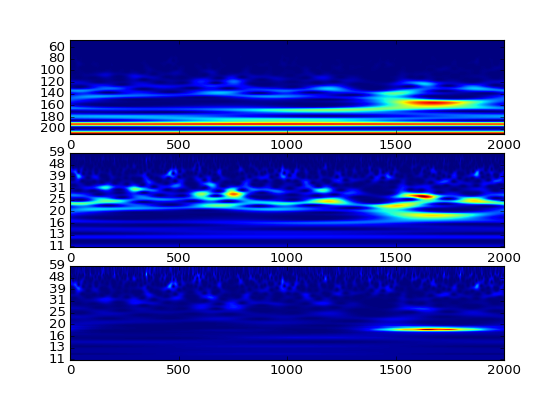

In [16]:
# Plot data
min_scale = 48
num_scales = 256 - 47
    
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(7, 5))

ax[0].imshow(S, origin='upper', extent=[0, S.shape[1], num_scales, min_scale], aspect='auto' )

# Scale Avg Spectra
ax[1].imshow(S_avg, origin='upper', extent=[0, S.shape[1], num_scales, min_scale], aspect='auto')
start = min_scale
end = num_scales
stepsize=20
ax[1].set_yticks(np.arange(start, end, stepsize))

labels = ax[1].get_yticks().tolist()
labels = fix_labels(labels)

for i in range(len(labels)):
    yVal = labels[i]
    if labels[i] <= len(scales):
        labels[i] = str(int(getRoundedThresholdv1(1 / scales[int(yVal)], 1)))
    else:
        labels[i] = "-1"
        
ax[1].set_yticklabels(labels)

# Z-norm Spectra
ax[2].imshow(zS, origin='upper', extent=[0, S.shape[1], num_scales, min_scale], aspect='auto')
start = min_scale
end = num_scales
stepsize=20
ax[2].set_yticks(np.arange(start, end, stepsize))

labels = ax[1].get_yticks().tolist()
labels = fix_labels(labels)

for i in range(len(labels)):
    yVal = labels[i]
    if labels[i] <= len(scales):
        labels[i] = str(int(getRoundedThresholdv1(1 / scales[int(yVal)], 1)))
    else:
        labels[i] = "-1"
        
ax[2].set_yticklabels(labels)

In [17]:
S_avg_seg = S_avg[38:,:]
print(S_avg_seg.shape)
block_S = block_mean(S_avg_seg, 30, 20)
print(block_S.shape)

(600, 2000)
(20, 100)


<IPython.core.display.Javascript object>


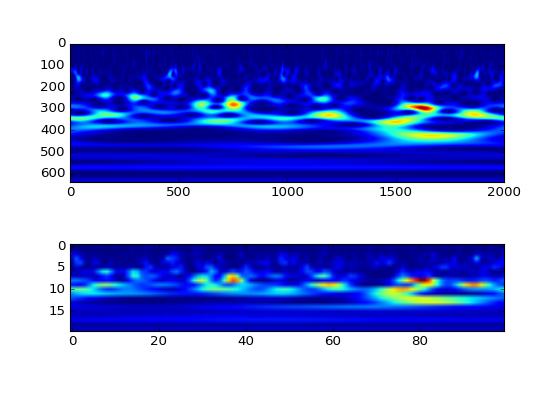

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(7, 5))
ax[0].imshow(S_avg)
ax[1].imshow(block_S)

In [20]:
k = np.array([[0, 0, 0],
              [1, 1, 1],
              [0, 0, 0]])
block_S_S = ndimage.filters.convolve(block_S, k, mode='constant')

<IPython.core.display.Javascript object>


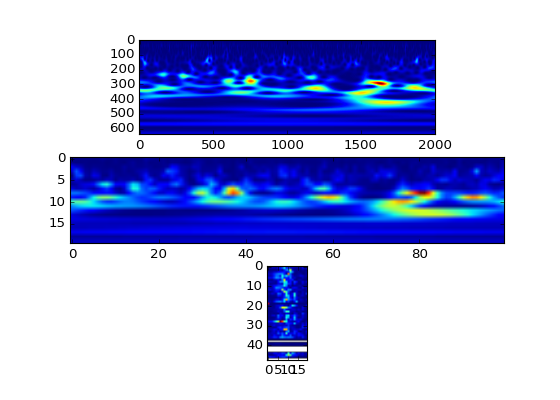

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(7, 5))
ax[0].imshow(S_avg)
ax[1].imshow(block_S)
ax[2].imshow(block_S_S)

In [22]:
num_chunks = ii_data.shape[1] / 2000 - 1
num_channels = ii_data.shape[0]

input_arr = np.zeros((num_chunks*100, 48, 20))

for i in range(num_chunks):
    for j in range(num_channels):
        ii_dataseg = ii_data[j, i*2000:(i+1)*2000]
        S_avg = scale_avg_spectra(ii_dataseg)
        S_avg_seg = S_avg[38:,:]
        block_S = block_mean(S_avg_seg, 30, 20)
        
        for k in range(100):
            input_arr[i*100 + k, j, :] = block_S[:, k]

<IPython.core.display.Javascript object>


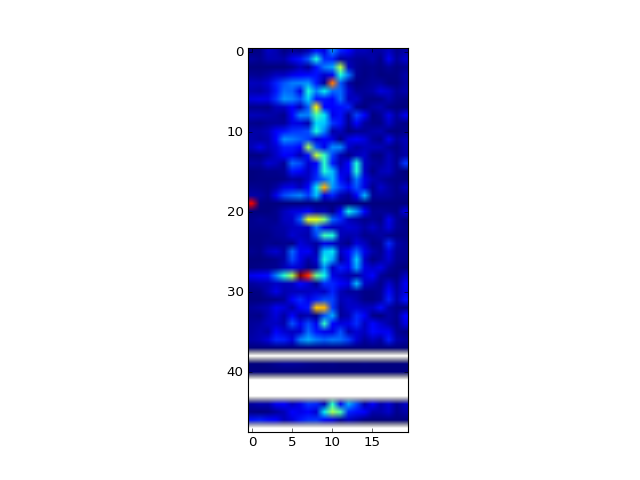

In [26]:
plt.figure()
plt.imshow(input_arr[0])

In [29]:
input_arr = np.nan_to_num(input_arr)
h5f = h5py.File('data/ii_data.h5', 'w')
h5f.create_dataset('ii_data', data=input_arr)
h5f.close()

In [5]:
# Load pi data
h5f = h5py.File('data/pi_data.h5','r')
pi_data = h5f['pi_data'][:]
h5f.close()

In [6]:
num_chunks = pi_data.shape[1] / 2000 - 1
num_channels = pi_data.shape[0]

input_arr = np.zeros((num_chunks*100, 48, 20))

for i in range(num_chunks):
    for j in range(num_channels):
        pi_dataseg = pi_data[j, i*2000:(i+1)*2000]
        S_avg = scale_avg_spectra(pi_dataseg)
        S_avg_seg = S_avg[38:,:]
        block_S = block_mean(S_avg_seg, 30, 20)
        
        for k in range(100):
            input_arr[i*100 + k, j, :] = block_S[:, k]

In [8]:
input_arr = np.nan_to_num(input_arr)
h5f = h5py.File('data/pi_data.h5', 'w')
h5f.create_dataset('pi_data', data=input_arr)
h5f.close()